# 1. Maximize the return on marketing campaigns

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Tuned Model Mean Squared Error (MSE): 901.92
Tuned Model Mean Absolute Error (MAE): 20.74
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


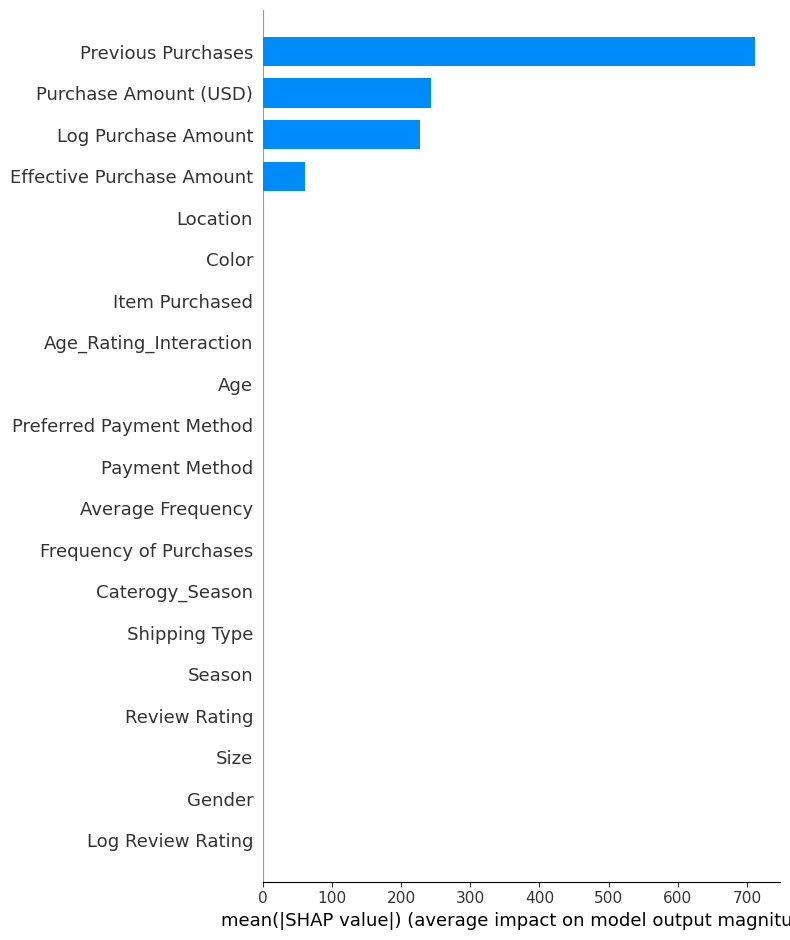

Customer Segment Analysis:
                       Age    Gender  Item Purchased  Category  \
Customer Segment                                                 
Low               0.014036  0.084725        0.128976  0.065725   
Medium           -0.037219  0.008199       -0.127099 -0.065725   
High             -0.044975  0.095657       -0.028388 -0.008573   
Premium           0.101710  0.106590       -0.056285 -0.008573   

                  Purchase Amount (USD)  Location      Size     Color  \
Customer Segment                                                        
Low                           -0.616035  0.051270  0.032168  0.070105   
Medium                        -0.537836 -0.083647  0.004497 -0.042916   
High                           0.034903 -0.086893 -0.023175 -0.061397   
Premium                        0.799132 -0.046130  0.010031  0.019636   

                    Season  Review Rating  ...  Caterogy_Season  \
Customer Segment                           ...                    
Low

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap
import warnings
warnings.filterwarnings('ignore')
trends=pd.read_csv('trends.csv')
data=trends.copy()

# Step 1: Data Preprocessing
data['Average Frequency'].fillna(data['Average Frequency'].mean(), inplace=True)

categorical_cols = ['Item Purchased', 'Category', 'Color', 'Discount Applied', 
                    'Preferred Payment Method', 'Frequency of Purchases', 'Caterogy_Season']
label_encoders = {col: LabelEncoder().fit(data[col]) for col in categorical_cols}
data[categorical_cols] = data[categorical_cols].apply(lambda col: label_encoders[col.name].transform(col))

X = data.drop(columns=['Customer ID', 'Customer Value'])
y = data['Customer Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# Step 2: Model Training with Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Step 3: Evaluation
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Tuned Model Mean Squared Error (MSE): {mse:.2f}")
print(f"Tuned Model Mean Absolute Error (MAE): {mae:.2f}")
print("Best Parameters:", grid_search.best_params_)

# Step 4: Customer Insights Using SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Summary Plot to Identify Key Drivers of Customer Value
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Step 5: Actionable Insights for Marketing Campaigns
# Classify customers into segments based on predicted values
X_test['Predicted Value'] = y_pred
X_test['Customer Segment'] = pd.qcut(X_test['Predicted Value'], q=4, labels=['Low', 'Medium', 'High', 'Premium'])

# Analyze each segment
segment_analysis = X_test.groupby('Customer Segment').mean()
print("Customer Segment Analysis:")
print(segment_analysis)

# Suggest marketing strategies
for segment in ['Low', 'Medium', 'High', 'Premium']:
    print(f"\nMarketing Strategy for {segment} Segment:")
    if segment == 'Low':
        print("Focus on retention campaigns with incentives or discounts.")
    elif segment == 'Medium':
        print("Promote loyalty programs and personalized offers.")
    elif segment == 'High':
        print("Upsell complementary products and emphasize quality.")
    elif segment == 'Premium':
        print("Provide exclusive services or rewards to sustain engagement.")


# 2. Improve customer retention

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       558
           1       0.63      0.88      0.73       222

    accuracy                           0.82       780
   macro avg       0.79      0.84      0.80       780
weighted avg       0.85      0.82      0.83       780



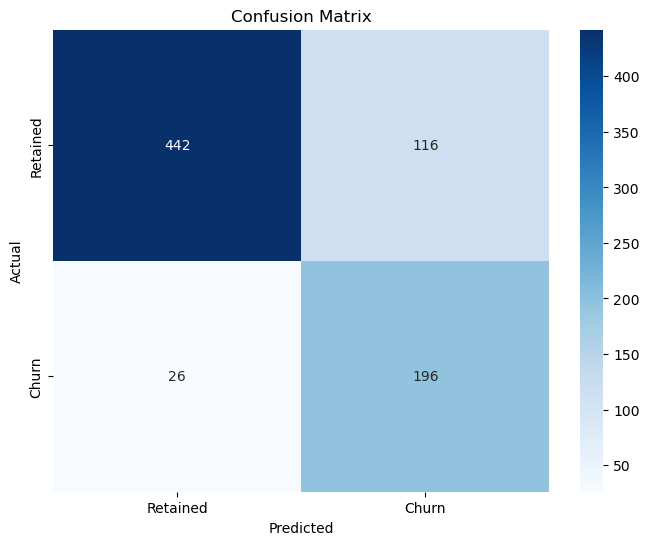

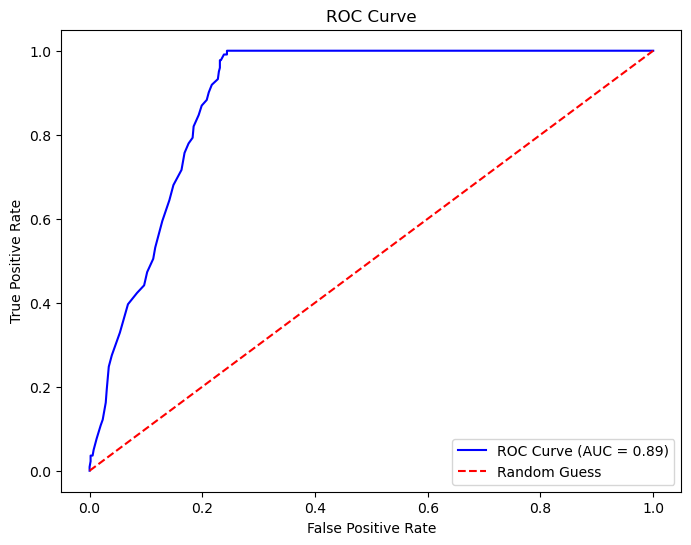

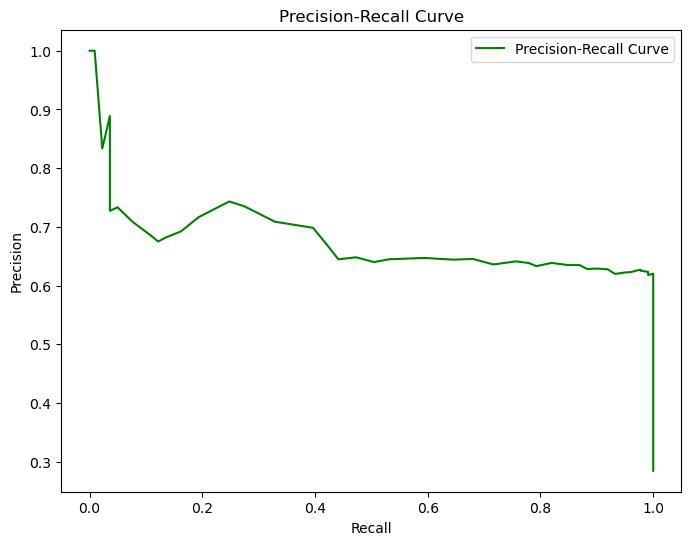

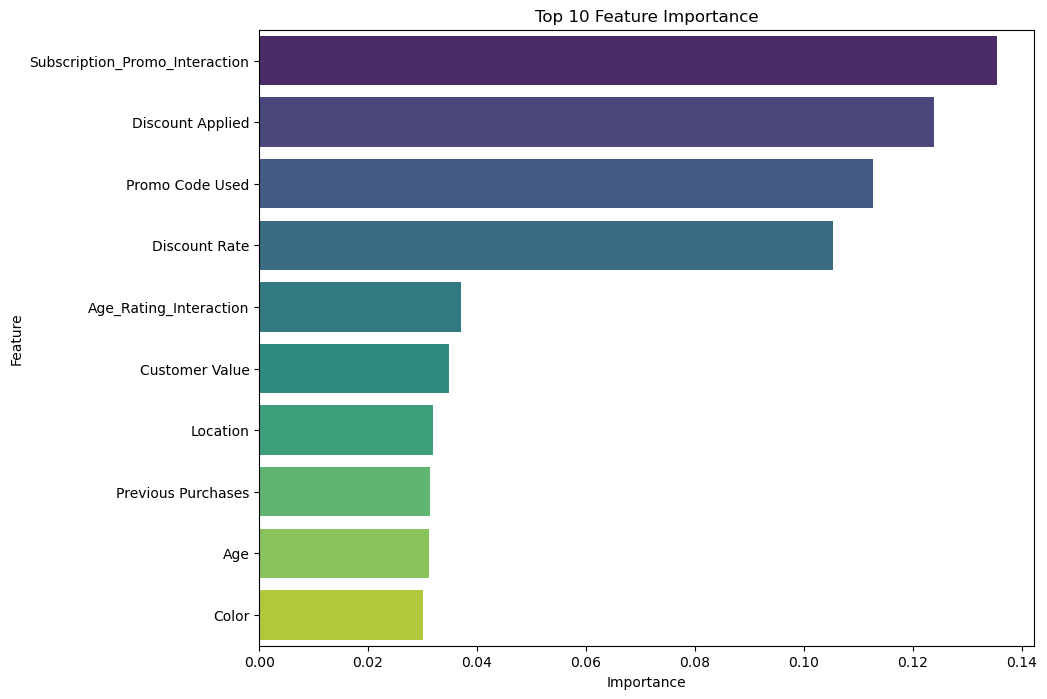


High-Risk Customers (Top 5):
   Customer ID  Churn_Probability
1            2               0.79
2            3               0.88
3            4               0.86
4            5               0.92
5            6               0.80

Suggestions:
- Offer discounts or free services to high-risk customers.
- Focus on improving services or addressing complaints for identified segments.
- Develop loyalty programs to retain customers in specific categories.


In [9]:
# === Import Libraries ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve
)
import warnings
warnings.filterwarnings('ignore')

# === Load Dataset ===
trends = pd.read_csv('trends.csv')
data = trends.copy()

# === Data Preprocessing ===
# 1. Handle missing values
data.fillna(data.median(numeric_only=True), inplace=True)

# 2. Encode categorical columns
label_encoder = LabelEncoder()
categorical_columns = [
    'Gender', 'Item Purchased', 'Category', 'Color', 
    'Discount Applied', 'Preferred Payment Method', 
    'Frequency of Purchases', 'Caterogy_Season'
]
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

# 3. Standardize feature columns
features = data.drop(columns=['Customer ID', 'Subscription Status'])  # Exclude ID and target column
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 4. Split data into training and testing sets
X = scaled_features
y = data['Subscription Status']  # Target: Subscription Status
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Model Training and Optimization with Grid Search ===
# Define parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize and execute Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',  # Optimize for ROC-AUC
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Extract the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# === Evaluate the Best Model ===
# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Retained', 'Churn'], yticklabels=['Retained', 'Churn'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve and AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve', color='green')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

# === Feature Importance Analysis ===
feature_importance = pd.DataFrame({
    'Feature': features.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10), palette='viridis')
plt.title("Top 10 Feature Importance")
plt.show()

# === Identify High-Risk Customers ===
data['Churn_Probability'] = best_model.predict_proba(scaled_features)[:, 1]
high_risk_customers = data[data['Churn_Probability'] > 0.7]  # Threshold for high-risk classification
print("\nHigh-Risk Customers (Top 5):")
print(high_risk_customers[['Customer ID', 'Churn_Probability']].head(5))

# === Suggestions for Retention ===
print("\nSuggestions:")
print("- Offer discounts or free services to high-risk customers.")
print("- Focus on improving services or addressing complaints for identified segments.")
print("- Develop loyalty programs to retain customers in specific categories.")


# 3. Maximize customer value

Baseline Mean Squared Error: 968.0135316666668
Baseline Mean Absolute Error: 21.51044871794872
Baseline R2 Score: 0.9992028413234804
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Optimized Mean Squared Error: 920.7675994230772
Optimized Mean Absolute Error: 20.992461538461544
Optimized R2 Score: 0.9992417483258994


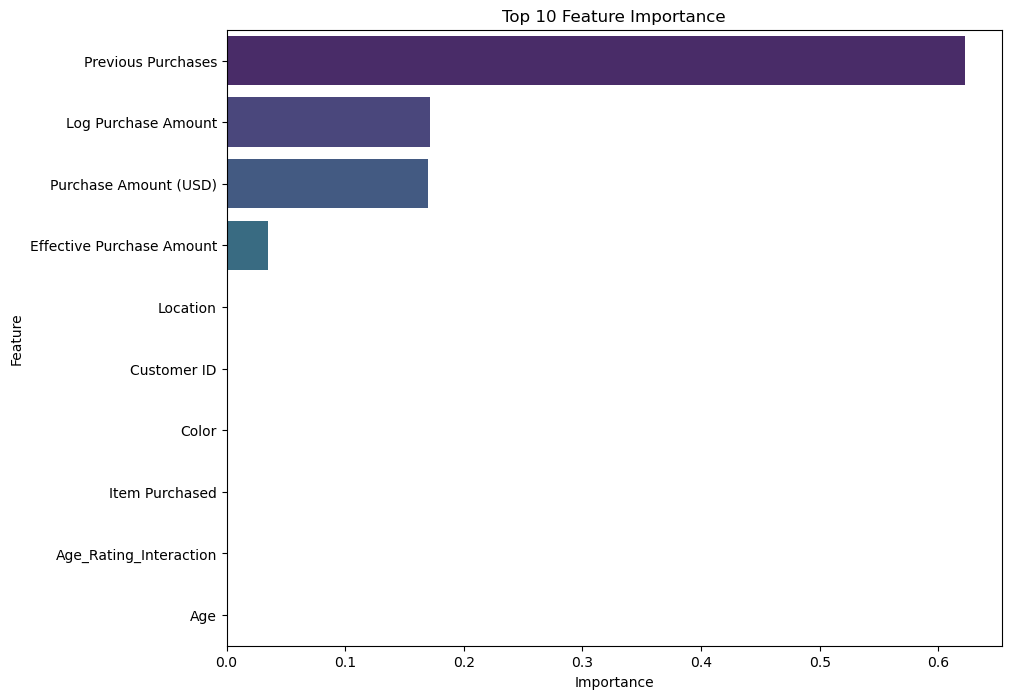

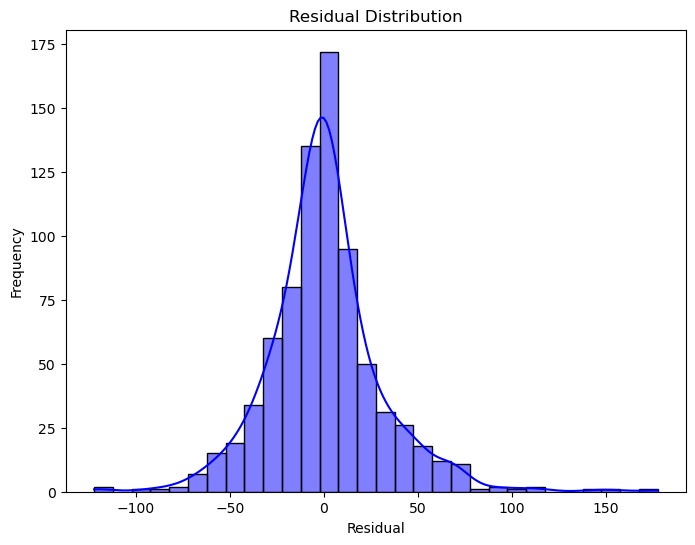


Top High-Value Customers:
    Customer ID  Predicted_Customer_Value
3             4                  4386.715
6             7                  4197.845
19           20                  4166.420
23           24                  3520.365
28           29                  3840.090

Suggestions:
- Focus on retaining high-value customers with personalized offers.
- Use insights from feature importance to identify key drivers of customer value.
- Continuously monitor and predict customer value to adjust strategies dynamically.


In [11]:
# === Import Libraries ===
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# === Load and Copy Data ===
trends = pd.read_csv('trends.csv')
data = trends.copy()

# === 1. Data Preprocessing ===

# 1.1 Handle Missing Values
data['Average Frequency'].fillna(data['Average Frequency'].mean(), inplace=True)

# 1.2 Encode Categorical Columns
label_encoders = {}
categorical_cols = [
    'Item Purchased', 'Category', 'Color', 'Discount Applied',
    'Preferred Payment Method', 'Frequency of Purchases', 'Caterogy_Season'
]
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# 1.3 Split Data into Features and Target
X = data.drop(['Customer Value'], axis=1)
y = data['Customer Value']

# 1.4 Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1.5 Standardize the Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === 2. Train Baseline Model ===
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# 2.1 Predict and Evaluate Baseline Model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Mean Squared Error: {mse}")
print(f"Baseline Mean Absolute Error: {mae}")
print(f"Baseline R2 Score: {r2}")

# === 3. Model Optimization with Grid Search ===
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Extract the Best Model
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# 3.1 Evaluate the Optimized Model
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Optimized Mean Squared Error: {mse_best}")
print(f"Optimized Mean Absolute Error: {mae_best}")
print(f"Optimized R2 Score: {r2_best}")

# === 4. Analysis and Visualization ===

# 4.1 Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10), palette='viridis')
plt.title("Top 10 Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# 4.2 Residual Analysis
residuals = y_test - y_pred_best
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# 4.3 Analyze High-Value Customers
data['Predicted_Customer_Value'] = best_model.predict(scaler.transform(X))
high_value_customers = data[data['Predicted_Customer_Value'] > data['Predicted_Customer_Value'].quantile(0.9)]
print("\nTop High-Value Customers:")
print(high_value_customers[['Customer ID', 'Predicted_Customer_Value']].head(5))

# === 5. Recommendations ===
print("\nRecommendations:")
print("- Focus on retaining high-value customers with personalized offers.")
print("- Use insights from feature importance to identify key drivers of customer value.")
print("- Continuously monitor and predict customer value to adjust strategies dynamically.")


# 4. Identify and delight highly-valued customers

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Cross-Validation ROC-AUC Scores: [0.99972223 0.99983883 0.99979976 0.99968743 0.99982906]
Mean ROC-AUC Score: 0.9998

Test ROC-AUC Score: 0.9998

Confusion Matrix:
[[455   5]
 [  4 442]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       460
           1       0.99      0.99      0.99       446

    accuracy                           0.99       906
   macro avg       0.99      0.99      0.99       906
weighted avg       0.99      0.99      0.99       906



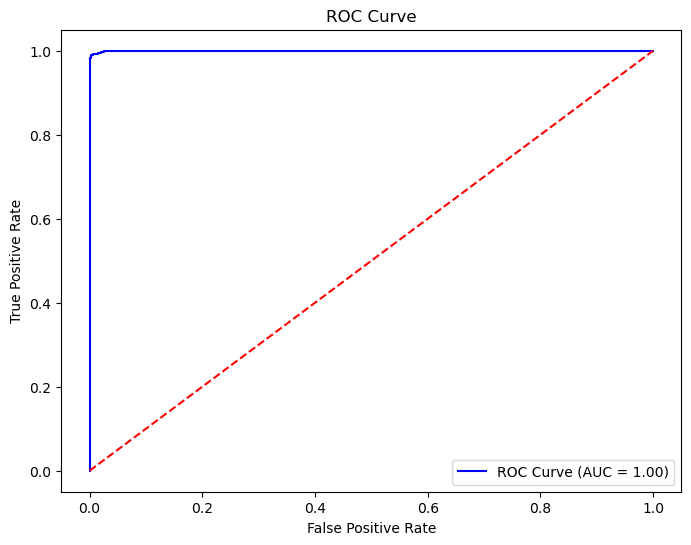

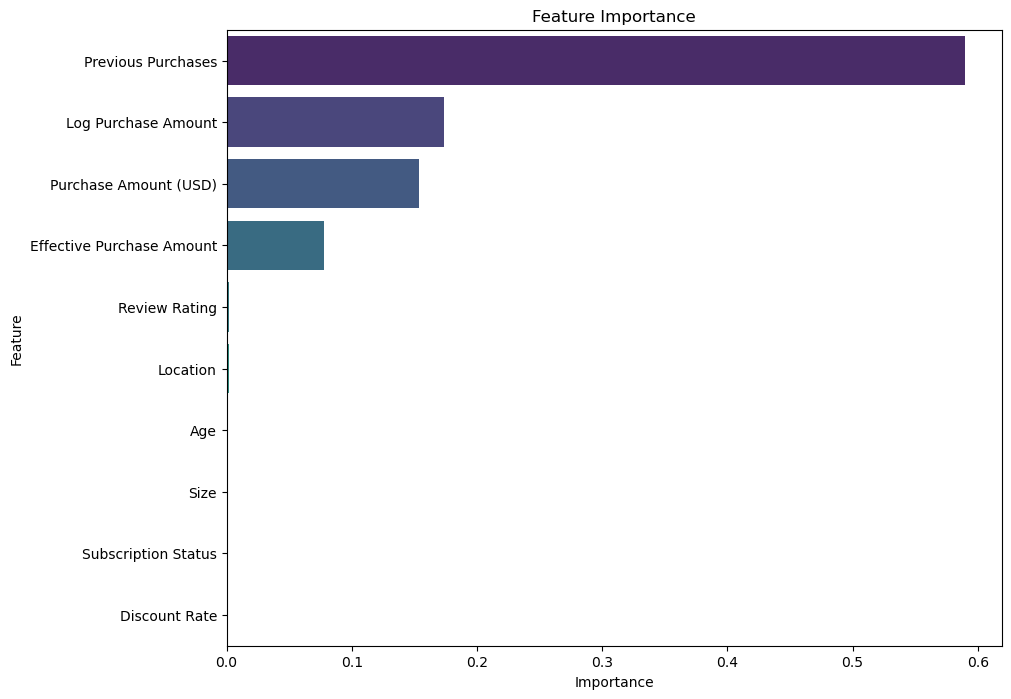

The list of high-value customers has been saved!


In [13]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
trends = pd.read_csv('trends.csv')
data = trends.copy()

# === 1. Data Preprocessing ===
# 1.1 Handle missing values
data['Average Frequency'].fillna(data['Average Frequency'].mean(), inplace=True)

# 1.2 Select initial features
features = [
    'Age', 'Gender', 'Purchase Amount (USD)', 'Location', 'Size', 'Season', 
    'Review Rating', 'Subscription Status', 'Promo Code Used', 'Previous Purchases', 
    'Log Purchase Amount', 'Discount Rate', 'Effective Purchase Amount', 
    'Payment_Match', 'Subscription_Promo_Interaction'
]
X = data[features]

# 1.3 Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1.4 Handle class imbalance using SMOTE
y = (data['Customer Value'] > data['Customer Value'].mean()).astype(int)  # 1: High value, 0: Low value
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# === 2. Feature Selection with RFE ===
rfe = RFE(estimator=GradientBoostingClassifier(random_state=42), n_features_to_select=10)
X_resampled_rfe = rfe.fit_transform(X_resampled, y_resampled)

# === 3. Split the data ===
X_train, X_test, y_train, y_test = train_test_split(X_resampled_rfe, y_resampled, test_size=0.2, random_state=42)

# === 4. Hyperparameter Tuning with Grid Search ===
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
}
gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Use the best model from Grid Search
best_model = grid_search.best_estimator_

# === 5. Model Evaluation ===
# 5.1 Cross-validation scores
cv_scores = cross_val_score(
    best_model, X_resampled_rfe, y_resampled, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='roc_auc'
)
print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Mean ROC-AUC Score: {cv_scores.mean():.4f}")

# 5.2 Evaluate on the test set
y_pred = best_model.predict(X_test)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
print(f"\nTest ROC-AUC Score: {roc_auc:.4f}")

# 5.3 Classification metrics
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# === 6. Visualize the ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# === 7. Feature Importance Visualization ===
feature_importance = pd.DataFrame({
    'Feature': [features[i] for i in range(len(features)) if rfe.support_[i]],
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# === 8. Export High-Value Customers ===
data['Predicted_High_Value'] = best_model.predict(scaler.transform(X)[:, rfe.support_])
high_value_customers = data[data['Predicted_High_Value'] == 1]

#high_value_customers.to_csv('high_value_customers.csv', index=False)
#print("The list of high-value customers has been saved!")


# 5. Manage brand image

In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load and copy dataset
trends = pd.read_csv('trends.csv')
data = trends.copy()

# Convert the "Review Rating" column into sentiment labels (0: Negative, 1: Positive)
data['Sentiment'] = np.where(data['Review Rating'] > 3, 1, 0)

# Define features potentially related to sentiment analysis
features = [
    'Age', 'Gender', 'Item Purchased', 'Category', 'Purchase Amount (USD)',
    'Location', 'Size', 'Color', 'Season', 'Promo Code Used',
    'Previous Purchases', 'Discount Applied', 'Payment Method',
    'Shipping Type', 'Frequency of Purchases'
]

# Categorical columns to process
categorical_columns = [
    'Gender', 'Item Purchased', 'Category', 'Location', 'Size',
    'Color', 'Season', 'Promo Code Used', 'Discount Applied',
    'Payment Method', 'Shipping Type', 'Frequency of Purchases'
]

# Encode categorical columns using LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Standardize numerical columns
numerical_columns = ['Age', 'Purchase Amount (USD)', 'Previous Purchases']
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Split data into features (X) and target (y)
X = data[features]
y = data['Sentiment']

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize the GradientBoostingClassifier
model = GradientBoostingClassifier(random_state=42)

# Perform cross-validation to evaluate model accuracy
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Tune hyperparameters using GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='accuracy',
    verbose=2
)
grid_search.fit(X_train, y_train)

# Print the best parameters from GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Predict using the best model from GridSearchCV
best_model = grid_search.best_estimator_
y_pred_optimized = best_model.predict(X_test)

# Evaluate the optimized model
print("Optimized Accuracy:", accuracy_score(y_test, y_pred_optimized))
print("\nOptimized Classification Report:\n", classification_report(y_test, y_pred_optimized))


Cross-Validation Accuracy Scores: [0.70522006 0.74206755 0.75127943 0.70726714 0.73360656]
Mean Cross-Validation Accuracy: 0.7278881487323187
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Optimized Accuracy: 0.8518821603927987

Optimized Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.81      0.84       588
           1       0.84      0.89      0.86       634

    accuracy                           0.85      1222
   macro avg       0.85      0.85      0.85      1222
weighted avg       0.85      0.85      0.85      1222

